<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_10_2D_FRAME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== DISPLACEMENTS ===
DOF  1 :  0.000000e+00
DOF  2 : -1.528265e-15
DOF  3 : -1.039423e-15
DOF  4 :  0.000000e+00
DOF  5 :  0.000000e+00
DOF  6 : -1.349563e+00
DOF  7 : -1.349563e+00
DOF  8 :  0.000000e+00
DOF  9 :  0.000000e+00
DOF 10 : -5.425656e-04
DOF 11 :  5.425656e-04
DOF 12 :  0.000000e+00

=== REACTIONS ===
DOF  1 :  1.069786e-11
DOF  4 :  7.275958e-12
DOF  5 :  1.000000e+04
DOF  8 :  1.000000e+04
DOF  9 :  2.259592e+07
DOF 12 : -2.259592e+07


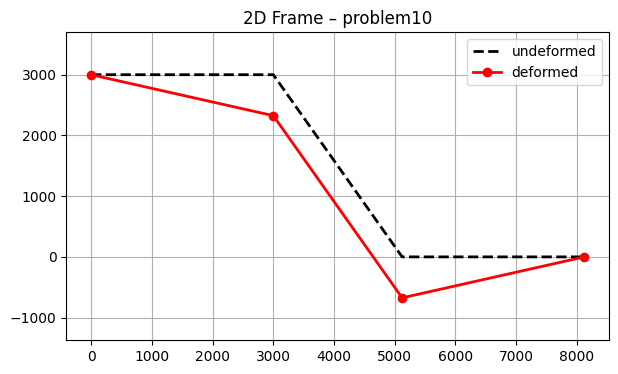

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# SOLVER
# ============================================================
def solution(GDof, prescribedDof, K, F):
    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)
    all_dofs = np.arange(GDof)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof)

    K_ff = K[np.ix_(free, free)]
    F_f  = F[free]

    U[free] = np.linalg.solve(K_ff, F_f)
    return U


def outputDisplacementsReactions(U, K, F, prescribedDof):
    R = K @ U - F
    print("=== DISPLACEMENTS ===")
    for i, ui in enumerate(U, start=1):
        print(f"DOF {i:2d} : {ui: .6e}")

    print("\n=== REACTIONS ===")
    for d in prescribedDof:
        print(f"DOF {d:2d} : {R[d-1]: .6e}")


# ============================================================
# STIFFNESS MATRIX – 2D FRAME
# ============================================================
def formStiffness2Dframe(GDof, numberElements, elementNodes, numberNodes, xx, yy, EI, EA):
    K = np.zeros((GDof, GDof))

    for e in range(numberElements):
        indice = elementNodes[e, :]      # MATLAB-style (1-based)
        i, j = int(indice[0]), int(indice[1])

        # Global DOF mapping (MATLAB style)
        elementDof = np.array([
            i-1,
            j-1,
            i-1 + numberNodes,
            j-1 + numberNodes,
            i-1 + 2*numberNodes,
            j-1 + 2*numberNodes
        ], dtype=int)

        xa = xx[j-1] - xx[i-1]
        ya = yy[j-1] - yy[i-1]
        L  = np.sqrt(xa**2 + ya**2)

        cosa = xa / L
        sena = ya / L

        # Transformation matrix
        T = np.block([
            [ cosa*np.eye(2),  sena*np.eye(2), np.zeros((2,2)) ],
            [-sena*np.eye(2),  cosa*np.eye(2), np.zeros((2,2)) ],
            [ np.zeros((2,4)), np.eye(2) ]
        ])

        # Local stiffness matrices
        oneu = np.array([[ 1, -1],
                         [-1,  1]])

        oneu2 = oneu.copy()
        oneu3 = np.array([[ 1,  1],
                          [-1, -1]])

        oneu4 = np.array([[4, 2],
                          [2, 4]])

        k1 = np.block([
            [ EA/L * oneu,             np.zeros((2,2)),              np.zeros((2,2)) ],
            [ np.zeros((2,2)), 12*EI/L**3 * oneu2,  6*EI/L**2 * oneu3 ],
            [ np.zeros((2,2)),  6*EI/L**2 * oneu3.T, EI/L * oneu4   ]
        ])

        K[np.ix_(elementDof, elementDof)] += T.T @ k1 @ T

    return K


# ============================================================
# MAIN – problem10
# ============================================================

# Material & section
E  = 210000
A  = 100
I  = 2e8
EA = E*A
EI = E*I

# Geometry
numberElements = 3
p1 = 3000*(1 + np.cos(np.pi/4))

nodeCoordinates = np.array([
    [0,    3000],
    [3000, 3000],
    [p1,      0],
    [p1+3000, 0]
], dtype=float)

xx = nodeCoordinates[:,0]
yy = nodeCoordinates[:,1]

elementNodes = np.array([
    [1, 2],
    [2, 3],
    [3, 4]
], dtype=int)

numberNodes = nodeCoordinates.shape[0]
GDof = 3 * numberNodes

# Force vector
F = np.zeros(GDof)

# Applied loads (as MATLAB)
F[5]  = -10000     # force(6)
F[6]  = -10000     # force(7)
F[9]  = -5e6       # force(10)
F[10] =  5e6       # force(11)

# Stiffness matrix
K = formStiffness2Dframe(GDof, numberElements, elementNodes,
                         numberNodes, xx, yy, EI, EA)

# Boundary conditions
prescribedDof = [1, 4, 5, 8, 9, 12]

# Solve
U = solution(GDof, prescribedDof, K, F)

# Output
outputDisplacementsReactions(U, K, F, prescribedDof)

# ============================================================
# PLOT DEFORMED / UNDEFORMED
# ============================================================

scale = 500

Ux = U[0:numberNodes]
Uy = U[numberNodes:2*numberNodes]

plt.figure(figsize=(7,4))
plt.plot(xx, yy, 'k--', lw=2, label='undeformed')
plt.plot(xx + scale*Ux, yy + scale*Uy, 'r-o', lw=2, label='deformed')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("2D Frame – problem10")
plt.show()
